In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import matplotlib.lines as mlines

In [4]:
individual_df = pd.read_csv("/Users/lanceoconnor/Desktop/JohnsHopkins/ANDERSEN_THESIS/projects/gene_annotation/processed_data/individual_concat.tsv", sep="\t", header=None, names=["CHROM", "START", "END", "SVtype", "STRAIN"])
print(individual_df[:5])

master_df = pd.read_csv("/Users/lanceoconnor/Desktop/JohnsHopkins/ANDERSEN_THESIS/projects/gene_annotation/processed_data/master.tsv", sep="\t", header=None, names=["CHROM", "START", "END", "SVtype", "STRAINS"])
print(master_df[:5])

print(individual_df.columns)
print(master_df.columns)

  CHROM  START    END SVtype  STRAIN
0     I    844    845    BND  CB4856
1     I  20104  20159    DEL  CB4856
2     I  30643  30741    INS  CB4856
3     I  43541  43844    INS  CB4856
4     I  51050  51136    DEL  CB4856
  CHROM  START   END SVtype                                            STRAINS
0     I    432   575    DEL  CX11314,ECA738,JU1409,JU775,LKC34,MY16,MY23,NI...
1     I   1383  3211    INS                                             ED3073
2     I   1671  1727    DEL  CX11314,JT11398,JU1409,JU775,LKC34,MY16,MY23,N...
3     I   2253  3356    DEL                                             XZ1516
4     I   2742  3371    INV                                            ECA1260
Index(['CHROM', 'START', 'END', 'SVtype', 'STRAIN'], dtype='object')
Index(['CHROM', 'START', 'END', 'SVtype', 'STRAINS'], dtype='object')


In [20]:
def plot_sv_corroboration(strain_name):
    # Filter individual calls for the given strain
    individual_strain_df = individual_df[individual_df["STRAIN"] == strain_name]

    # Filter master calls that contain this strain
    master_strain_df = master_df[master_df["STRAINS"].str.contains(strain_name, na=False)]

    individual_strain_df["source"] = "IND"
    master_strain_df["source"] = "MERG"

    # Expand master_df so each strain gets its own row (for easier filtering)
    master_expanded = master_strain_df.assign(Strain=master_strain_df["STRAINS"].str.split(",")).explode("Strain")

    master_filtered = master_expanded[master_expanded["Strain"] == strain_name].drop(columns=["Strain", "STRAINS"])    
    
    # Combine both dataframes
    plot_df = pd.concat([individual_strain_df, master_filtered])

    plot_df = plot_df[~plot_df["CHROM"].str.contains("MtDNA", case=False, na=False)]

    svtype_order = sorted(plot_df["SVtype"].unique())  # Sort SV type so it is plotted consistently
    plot_df["SVtype"] = pd.Categorical(plot_df["SVtype"], categories=svtype_order, ordered=True)

    plot_df["START"] = plot_df["START"] * 1e-6

    g = sns.FacetGrid(plot_df, col="CHROM", col_wrap=3, sharex=False, sharey=False, height=5, aspect=1.5) # 3 columns and then new line, don't share x and y axis, facet (col) by CHROM

    g.map_dataframe(sns.scatterplot, x="START", y="SVtype", hue="SVtype", style="source", palette="dark", alpha=0.7)

    g.set_axis_labels("Genomic Position (Mb)", "SV Type")

    g.set_titles(col_template="{col_name}", fontweight='bold', size=14) # only display the chromosome number

    g.add_legend()

    for text in g.legend.texts:
        if text.get_text() == "SVtype":
            text.set_text("SV Type")
        elif text.get_text() == "source":
            text.set_text("Analysis")

    plt.suptitle(f"{strain_name}", fontsize=16, fontweight='bold', y=1.025)

    # plt.gcf().savefig(f"/Users/lanceoconnor/Desktop/JohnsHopkins/ANDERSEN_THESIS/projects/gene_annotation/plots/{strain_name}_sniffles_corroboration.png", dpi=500, bbox_inches="tight")

    plt.show()



    # Counting SV calls 
    sv_counts = plot_df.groupby(["SVtype", "source"]).size().reset_index(name="count")

    print(f"SV calls for {strain_name}:")

    # Print the counts for each SVtype in the current strain
    for svtype in sv_counts["SVtype"].unique():
        counts = sv_counts[sv_counts["SVtype"] == svtype]
        
        # Ensure you access the correct rows for IND and MERG
        ind_count = counts[counts["source"] == "IND"]["count"].sum() if "IND" in counts["source"].values else 0
        merg_count = counts[counts["source"] == "MERG"]["count"].sum() if "MERG" in counts["source"].values else 0
        
        # Safely calculate percentage if IND count is non-zero
        if ind_count > 0:
            percentage = (merg_count / ind_count) * 100
        else:
            percentage = 0 
        
        print(f"{svtype}: IND({ind_count}); MERG({merg_count}); ({merg_count} / {ind_count} * 100) = {percentage:.2f}%")    



/var/folders/zb/zjdjqyj90wj8vkngpmq9_8vw0000gn/T/ipykernel_20139/2773885345.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  individual_strain_df["source"] = "IND"
/var/folders/zb/zjdjqyj90wj8vkngpmq9_8vw0000gn/T/ipykernel_20139/2773885345.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  master_strain_df["source"] = "MERG"


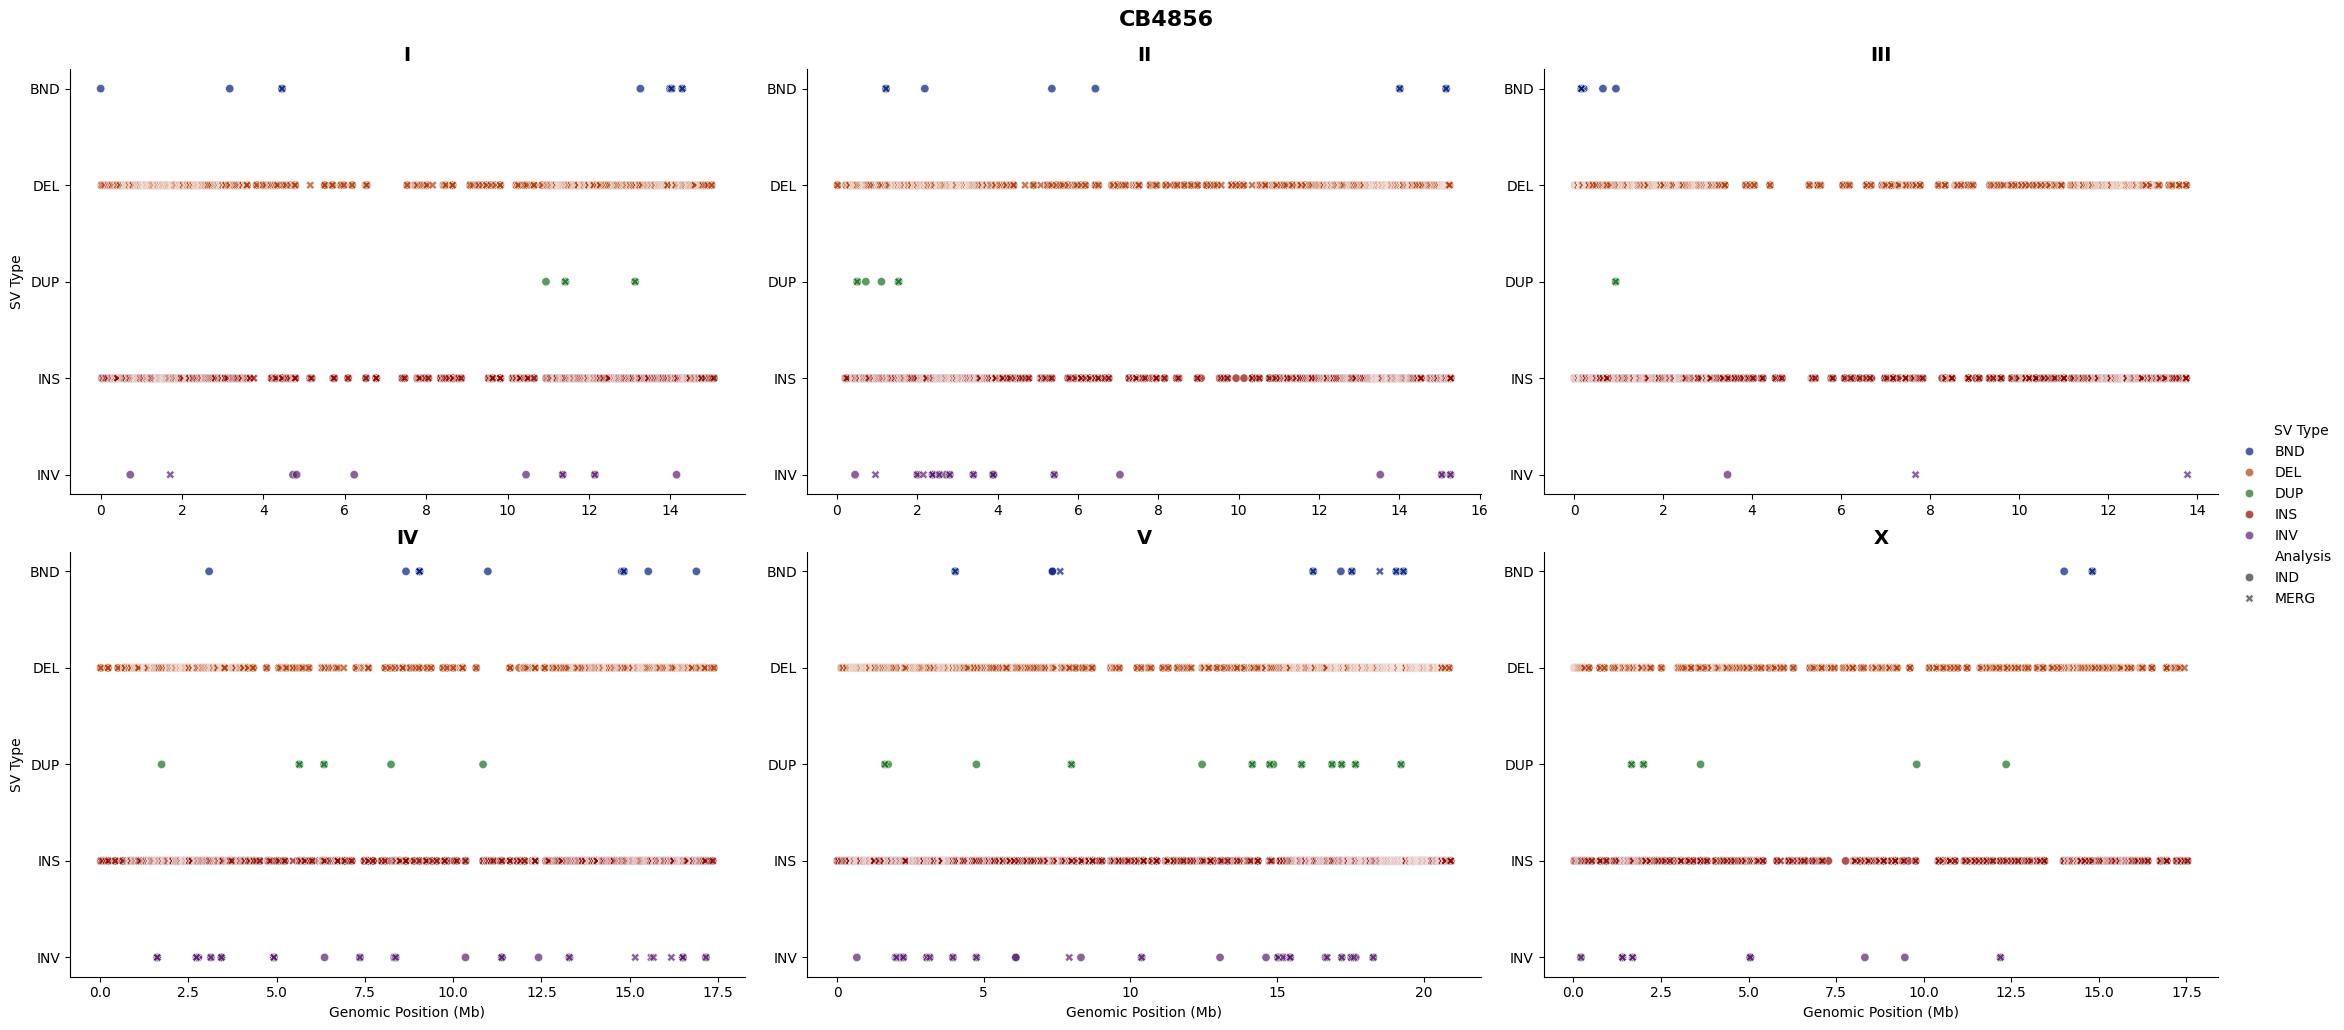

SV calls for CB4856:
BND: IND(37); MERG(20); (20 / 37 * 100) = 54.05%
DEL: IND(3694); MERG(3370); (3370 / 3694 * 100) = 91.23%
DUP: IND(31); MERG(18); (18 / 31 * 100) = 58.06%
INS: IND(3706); MERG(3697); (3697 / 3706 * 100) = 99.76%
INV: IND(86); MERG(67); (67 / 86 * 100) = 77.91%


/var/folders/zb/zjdjqyj90wj8vkngpmq9_8vw0000gn/T/ipykernel_20139/2773885345.py:51: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sv_counts = plot_df.groupby(["SVtype", "source"]).size().reset_index(name="count")


In [19]:
# for strain in individual_df["STRAIN"].unique():
#     # print(strain)
#     plot_sv_corroboration(f"{strain}")

plot_sv_corroboration("CB4856")

In [ ]:
def isolate_SV(strain, chromosome, start, end):
    CB_df = individual_df[individual_df["STRAIN"] == f"{strain}"]

    CB_master_df = master_df[master_df["STRAINS"].str.contains(f"{strain}", na=False)]

    CB_df["source"] = "IND"
    CB_master_df["source"] = "MERG"

    master_expanded = CB_master_df.assign(Strain=CB_master_df["STRAINS"].str.split(",")).explode("Strain")
    master_filtered = master_expanded[master_expanded["Strain"] == f"{strain}"].drop(columns=["Strain", "STRAINS"])    

    concat_df = pd.concat([CB_df, master_filtered])

    plot_df = concat_df[(concat_df["CHROM"] == f"{chromosome}") & (concat_df['START'] >= start) & (concat_df['END'] <= end)]

    svtype_to_y = {svtype: i for i, svtype in enumerate(plot_df["SVtype"].unique())}

    plt.figure(figsize=(15, 8))

    for _, row in plot_df.iterrows():
        # Get the numerical y-position for the SVtype
        y_position = svtype_to_y[row["SVtype"]]
        
        # Offset y for IND and MERG to avoid overlapping
        if row["source"] == "IND":
            y_position += 0.1  # Offset IND calls slightly upwards
        else:
            y_position -= 0.1  # Offset MERG calls slightly downwards

        plt.hlines(
            y=y_position,  # Adjusted Y position
            xmin=row["START"] * 1e-6,  # Convert START to Mb
            xmax=row["END"] * 1e-6,    # Convert END to Mb
            color="red" if row["source"] == "IND" else "purple",  # Color by source (IND or MERG)
            linewidth=2
        )

    plt.xlabel("Genomic Position (Mb)", fontsize=12)
    plt.ylabel("SV Type", fontsize=12)
    plt.title(f"{strain} ({chromosome})", fontsize=16, fontweight='bold')

    plt.yticks(list(svtype_to_y.values()), list(svtype_to_y.keys()), rotation=45)

    legend_ind = mlines.Line2D([], [], color="red", label="IND")
    legend_merg = mlines.Line2D([], [], color="purple", label="MERG")
    plt.legend(handles=[legend_ind, legend_merg], title="Source")

    plt.tight_layout()
    # plt.gcf().savefig(f"/Users/lanceoconnor/Desktop/JohnsHopkins/ANDERSEN_THESIS/projects/gene_annotation/plots/{strain}.{chromosome}_sniffles_corroboration_isolationSV.png", dpi=500, bbox_inches="tight")
    plt.show()

/var/folders/zb/zjdjqyj90wj8vkngpmq9_8vw0000gn/T/ipykernel_20139/2242111261.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  CB_df["source"] = "IND"
/var/folders/zb/zjdjqyj90wj8vkngpmq9_8vw0000gn/T/ipykernel_20139/2242111261.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  CB_master_df["source"] = "MERG"


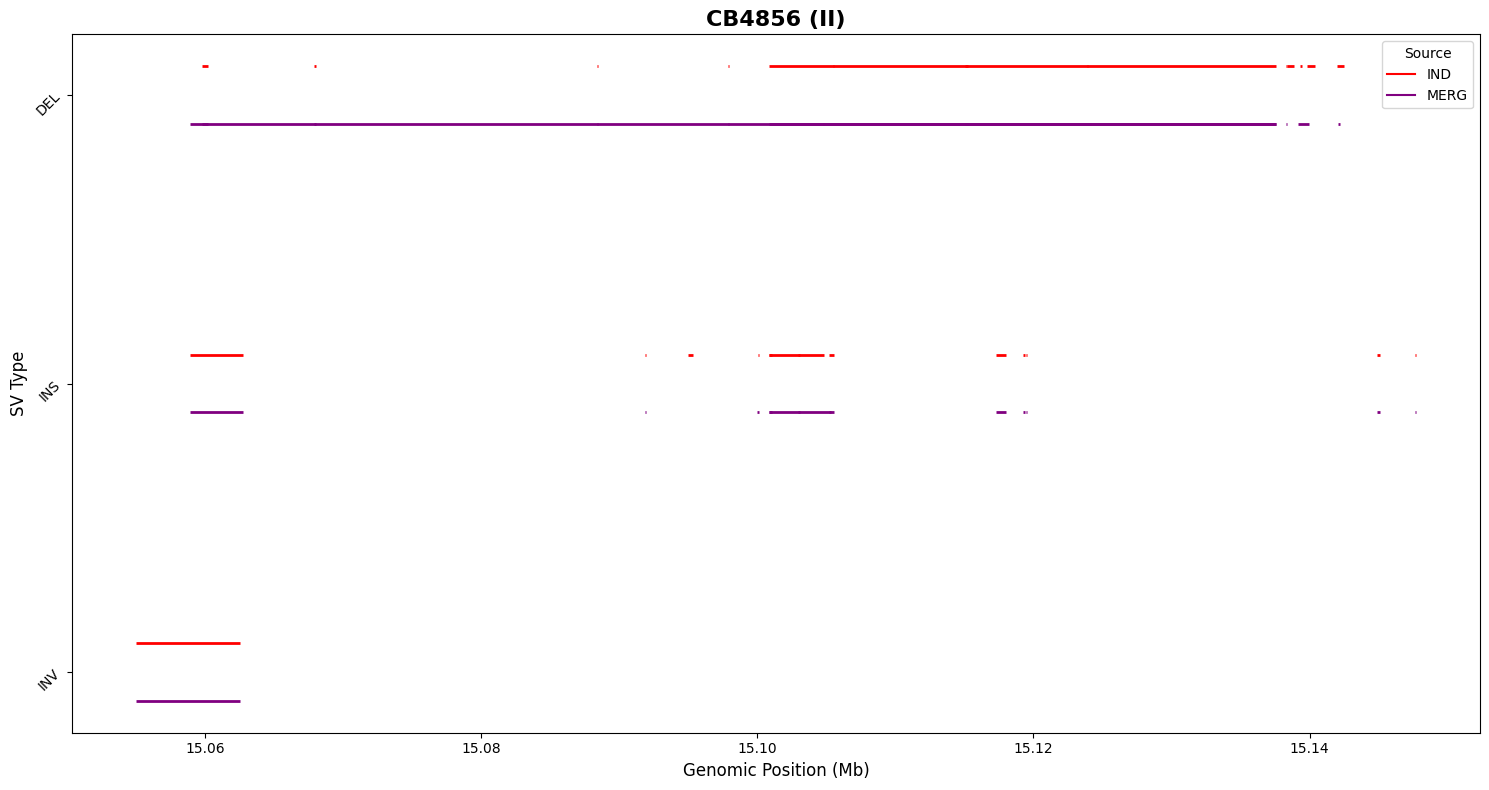

In [35]:
isolate_SV("CB4856","II",15050000,15150000)

/var/folders/zb/zjdjqyj90wj8vkngpmq9_8vw0000gn/T/ipykernel_20139/2242111261.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  CB_df["source"] = "IND"
/var/folders/zb/zjdjqyj90wj8vkngpmq9_8vw0000gn/T/ipykernel_20139/2242111261.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  CB_master_df["source"] = "MERG"


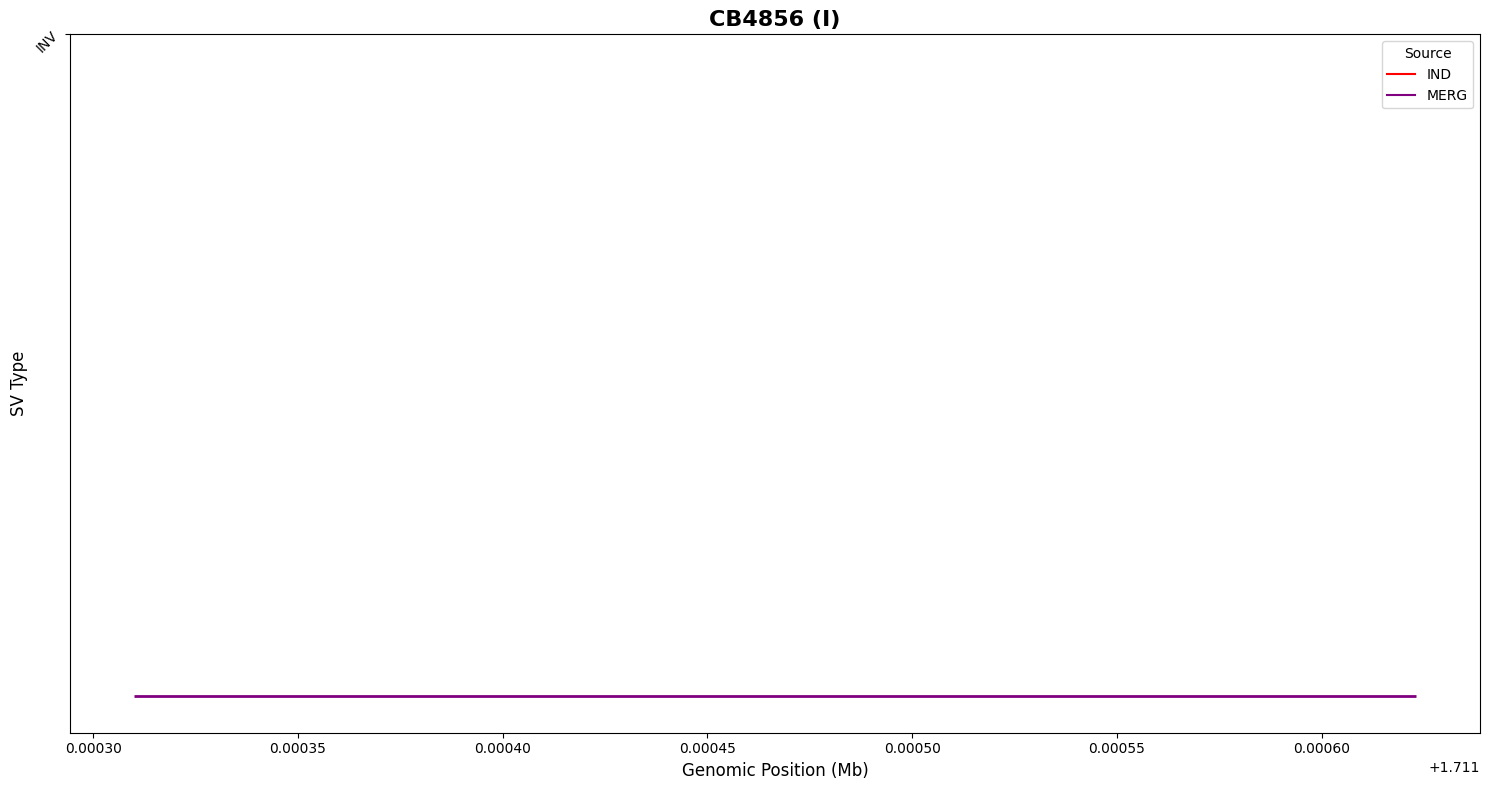

In [37]:
isolate_SV("CB4856","I",1711300,1711633)

/var/folders/zb/zjdjqyj90wj8vkngpmq9_8vw0000gn/T/ipykernel_20139/2242111261.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  CB_df["source"] = "IND"
/var/folders/zb/zjdjqyj90wj8vkngpmq9_8vw0000gn/T/ipykernel_20139/2242111261.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  CB_master_df["source"] = "MERG"


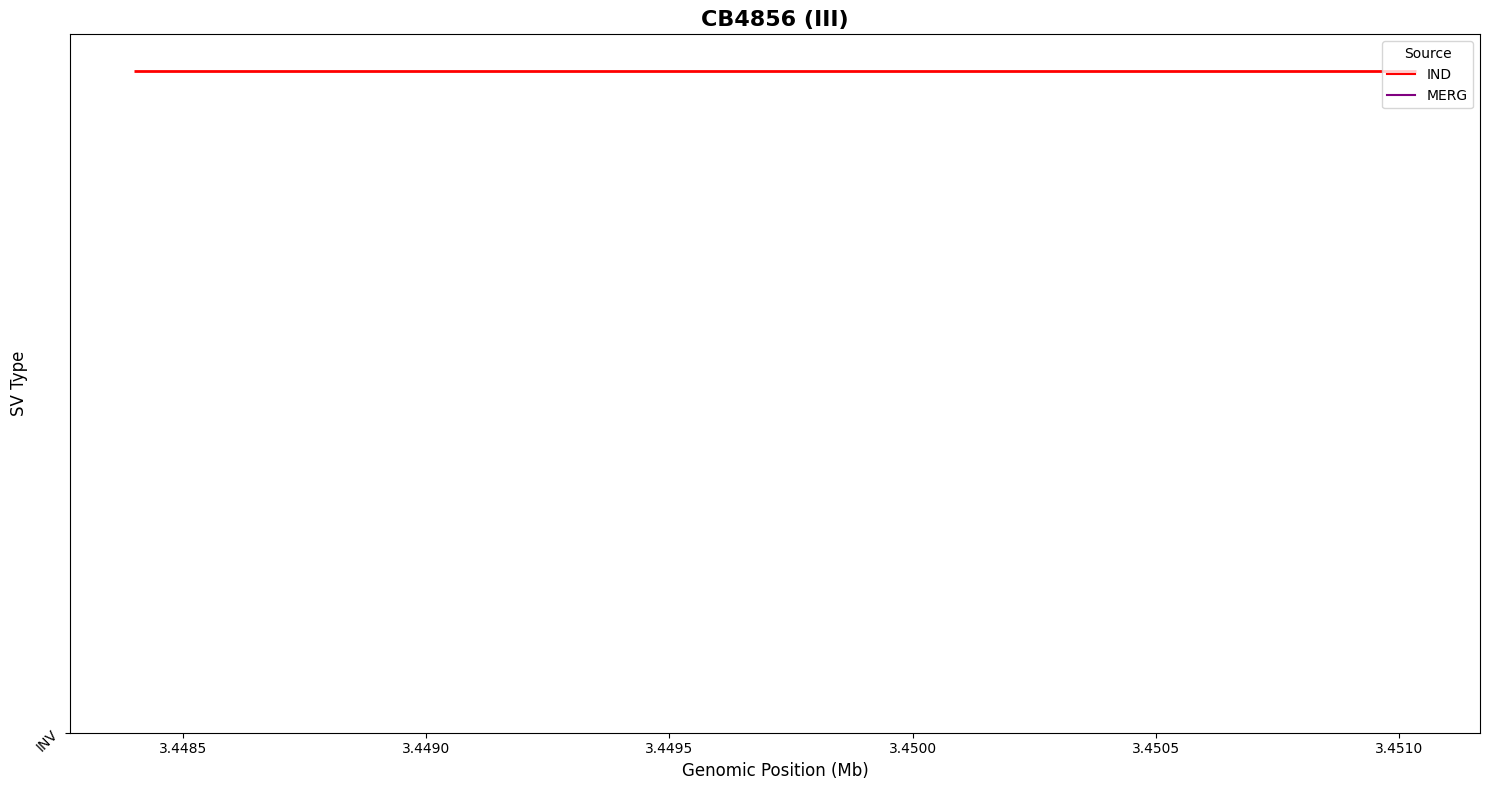

In [40]:
isolate_SV("CB4856","III",3448190,3451044)